In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from scipy.spatial.distance import mahalanobis

from IPython.display import display, Math, Latex

# Regression Analysis

#### Acquiring the dataset
Reference: https://qog.pol.gu.se/data/datadownloads/qogstandarddata

In [2]:
df_original = pd.read_csv("Datasets/qog_bas_cs_jan18.csv")
df = df_original[["cname","wdi_lifexp","wdi_popden","gle_cgdpc","bti_acp", "bti_pdi", "fh_pair", "al_ethnic","al_language","al_religion","bti_aar","vdem_gender","bti_ci","bti_foe","wdi_araland", "wdi_forest"]]
df = df.dropna()

for y in df.columns:
    if(df[y].dtype == np.object):
        df = df.drop([y], 1)
        
df.head()

,wdi_lifexp,wdi_popden,gle_cgdpc,bti_acp,bti_pdi,fh_pair,al_ethnic,al_language,al_religion,bti_aar,vdem_gender,bti_ci,bti_foe,wdi_araland,wdi_forest
0,62.902683,50.176178,1282.6400,3.0,3.0,2,0.769345,0.614146,0.271684,4.0,0.530792,9.0,4.0,11.903011,2.067825
1,77.998390,105.441750,8516.7002,5.0,6.0,9,0.220426,0.039925,0.471852,8.0,0.828077,3.0,7.0,22.467154,28.191971
2,75.635025,16.422152,5402.1699,5.0,3.0,7,0.339400,0.442662,0.009128,5.0,0.770516,7.0,6.0,3.136109,0.818057
4,60.806732,21.593380,3771.2000,2.0,3.0,3,0.786720,0.787019,0.627644,3.0,0.680371,4.0,4.0,3.930376,46.507420
6,71.724754,115.348816,9793.3096,2.0,2.0,6,0.204672,0.205392,0.489895,3.0,0.576483,4.0,3.0,23.305470,13.466484


#### Computing Pearson 's correlation coefficient between life expectancy and other values

In [3]:
life_expectancy = df['wdi_lifexp']
life_expectancy = life_expectancy.fillna(life_expectancy.mean())

def pearson_corr(first_column, second_column):
    second_column = second_column.fillna(second_column.mean())
    return np.cov(first_column, second_column)[1,0] / (np.std(first_column)*np.std(second_column))

data = [pearson_corr(life_expectancy, df[column]) for column in df.columns.values]
df_correlations = pd.DataFrame([data], columns = list(df.columns.values))
df_correlations.head()

,wdi_lifexp,wdi_popden,gle_cgdpc,bti_acp,bti_pdi,fh_pair,al_ethnic,al_language,al_religion,bti_aar,vdem_gender,bti_ci,bti_foe,wdi_araland,wdi_forest
0,1.008772,0.19213,0.50234,0.423312,0.199336,0.514225,-0.606459,-0.622697,-0.316992,0.15152,0.202752,-0.427087,0.154698,0.024731,0.088662


#### High correlations are to be seen in gender and gdp per capita - Attempting to predict life expectancy with these two variables via Ordinary Least Squares

In [8]:
X = df[['vdem_gender', 'gle_cgdpc']]
X = sm.add_constant(X)
Y = df['wdi_lifexp']

model = sm.OLS(Y, X)
results = model.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.285   
Dependent Variable: wdi_lifexp       AIC:                759.7281
Date:               2020-08-23 10:35 BIC:                767.9629
No. Observations:   115              Log-Likelihood:     -376.86 
Df Model:           2                F-statistic:        23.74   
Df Residuals:       112              Prob (F-statistic): 2.53e-09
R-squared:          0.298            Scale:              42.212  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
const         59.0930    2.7511  21.4798  0.0000  53.6421  64.5440
vdem_gender   10.4318    3.7021   2.8178  0.0057   3.0965  17.7670
gle_cgdpc      0.0003    0.0000   6.4068  0.0000   0.0002   0.0004
-----------------------------------------------------------------
Omnibus:              12.284       Durbin-Watson:          2.244 
Prob(Omnibus):        0.002        Jarque-Bera (JB):       14.017
Skew:                 -0.848       Prob(JB):               0.001 
Kurtosis:             2.779        Condition No.:          121441
=================================================================
* The condition number is large (1e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

P values seem low for these two variables, meaning that linear relationship is indeed present. 

#### Predicted vs real plot

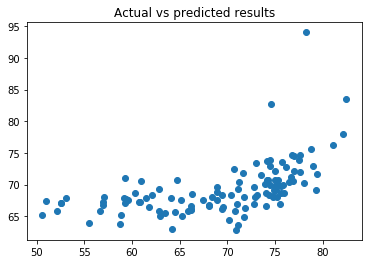

In [9]:
w0 = results.params.const
w1 = results.params.gle_cgdpc #Are these weights or X?
w2 = results.params.vdem_gender

real = np.array(Y)
predicted = np.array(results.predict(X))
no_of_instances = len(Y)
no_of_parameters = 3 # both X and Y vars 
_ = plt.scatter(real, predicted)
_ = plt.title(f'Actual vs predicted results')

#### Evaluation of results
<i>
    
- SSE: Sum of deviation of predicted results from its real values
    
- MSE: Mean of deviation of predicted results from its real values

- R2: Total variability explained by the model -> how close is the data to fitted regression line. 

- MALLOW: Relative measure for model selection in regression (closely related to AIC)    
</i>

<i>Potential problems with OLS: 
There shall be no dependent variables in X, as this is necessary for using closed form solution (Full rank). 
</i>

In [10]:
sse = round(np.sum((real-predicted)**2), 2)
mse = round(np.mean((real-predicted)**2), 2)
r2 = 1 - np.sum((real - predicted)**2) / np.sum((real-np.mean(real))**2)
mallow = round(sse/mse - no_of_instances + 2 * no_of_parameters, 2)

print(f'SSE: {sse} | MSE: {mse} | R2: {r2} | MALLOW: {mallow}')

SSE: 4727.79 | MSE: 41.11 | R2: 0.29775942662329014 | MALLOW: 6.0


#### Heteroscedascity check

<i>
Regression model can constantly be accurate for low/high values, but be inconsistent when predicting high/low values
(Residual becomes more increasing for higher prediction values). 
</i>

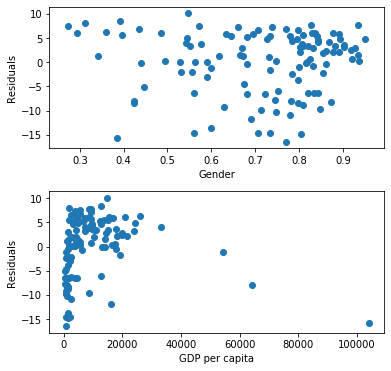

In [15]:
X = np.array(X)
Y = np.array(Y)
X1, X2 = X[:, 1], X[:, 2]

residuals = Y - predicted

fig, ax = plt.subplots(2,1, figsize=(6,6))
plt.subplots_adjust(hspace = 0.3)
ax[0].scatter(X1, residuals); ax[0].set_xlabel('Gender');
ax[1].scatter(X2, residuals); ax[1].set_xlabel('GDP per capita');
for i in range(0,2): 
    ax[i].set_ylabel('Residuals')

One can notice slightly higher residual for higher value of gender variable. Thus weighted regression might be a better choice. 

#### Building different regression models to model life expectancy (Ridge and Lasso)

In [25]:
def test_model(model, X, Y, degree=0):
    
    mse_list = []
    r2_list = []
    
    #9fold
    X_training, Y_training, X_test, Y_test = [], [], [], []
    kf = KFold(n_splits=10, random_state = None, shuffle=False)
    for train_idx, test_idx in kf.split(X):
        X_training, X_test = X[train_idx], X[test_idx]
        Y_training, Y_test = Y[train_idx], Y[test_idx]
        model.fit(X_training, Y_training)
        prediction = model.predict(X_test)
        mse_list.append(mean_squared_error(Y_test, prediction))
        r2_list.append(r2_score(Y_test, prediction))
    
    mse = np.mean(mse_list)
    r2 = np.mean(r2_list)
    model_name = str(type(model).__name__)
    if (degree!=0): return [model_name, float("%.4f"%mse), float("%.4f"%r2), degree]
    else: return [model_name, float("%.4f"%mse), float("%.4f"%r2)]

<i>Overfitting can occur. How to tackle it? 

One of the solutions could be applying Lasso/Ridge Regression/Regularization: We penalize huge weights by including them additionally multiplied with parameter lambda. </i> 

ref: https://www.youtube.com/watch?v=sO4ZirJh9ds

<img src="Images/regularization.png" style="width: 500px;"> 

In [26]:
display(Math(r'Lasso: \sum(\textbf{Y} - \textbf{X}{\beta} ) + \lambda\sum|\beta_j| \\ Ridge: \sum(\textbf{Y} - \textbf{X}{\beta} ) + \lambda\sum{\beta_j}^2'))

<IPython.core.display.Math object>

In [27]:
x_df = df.drop('wdi_lifexp', axis = 1)
filling_values = {column_name: x_df[column_name].mean() for column_name in x_df.columns.values}
x_df = x_df.fillna(value=filling_values)
y_df = df['wdi_lifexp'].fillna(value=df['wdi_lifexp'].mean())

X = preprocessing.scale(x_df.values)
Y = preprocessing.scale(y_df.values)

#List of models
models = [linear_model.LinearRegression(), linear_model.Ridge(alpha=10000), linear_model.Lasso(alpha=0.1)]
columns_names=['Model name', 'Mean squared error', 'R2 score', 'Degree']
results = [test_model(model, X, Y, degree=len(filling_values)) for model in models]

#Generating dataframe in form of results
pd.DataFrame(results, columns=columns_names)

,Model name,Mean squared error,R2 score,Degree
0,LinearRegression,0.5333,0.4359,14
1,Ridge,0.9754,-0.0166,14
2,Lasso,0.3964,0.5813,14


In [28]:
Y = y_df.values
X = x_df

def forward_selection(Y,X):
    models = []
    columns = X.columns.values
    #Start with no variables
    variables_chosen = []
    variables_not_chosen = columns
    while len(variables_not_chosen) > 0:
        # Test all models, where one variable is added and add the best one to the list of models
        best_model = (0,sys.maxsize,0,0)
        for variable in variables_not_chosen:
            variables_candidates = list(variables_chosen)
            variables_candidates.append(variable)
            model_tested = test_model(linear_model.LinearRegression(), X[variables_candidates].values, Y, degree=len(variables_candidates))
            if model_tested[1] < best_model[1]:
                best_model = model_tested
                best_variable = variable
        # Add the best model with k variables to the list of models
        variables_chosen.append(best_variable)
        variables_not_chosen = variables_not_chosen[variables_not_chosen!=best_variable]
        models.append(best_model)
        print(str(len(variables_chosen)) + " variable(s): " + str(variables_chosen))
        print("MSE: " + str(best_model[1]))
        
    # Choose the best model
    best_model_of_all = models[0]
    for model in models:
        if model[1] < best_model_of_all[1]:
            best_model_of_all = model
    print(">>>Result of forward selection<<<")
    print(">>>Number of variables of best model: " + str(best_model_of_all[3]))
    print(">>>MSE of best model: " + str(best_model_of_all[1]))
    return best_model_of_all

def backwards_selection(Y,X):
    models = []
    columns = X.columns.values
    #Start with no variables
    variables_chosen = columns
    variables_not_chosen = []
    while len(variables_chosen) > 1:
        # Test all models, where one variable is removed and add the best one to the list of models
        best_model = (0,sys.maxsize,0,0)
        for variable in variables_chosen:
            variables_candidates = list(variables_chosen)
            variables_candidates.remove(variable)
            model_tested = test_model(linear_model.LinearRegression(), X[variables_candidates].values, Y, degree=len(variables_candidates))
            if model_tested[1] < best_model[1]:
                best_model = model_tested
                best_variable = variable
        # Add the best model with k variables to the list of models
        variables_chosen = variables_chosen[variables_chosen!=best_variable]
        variables_not_chosen.append(best_variable)
        models.append(best_model)
        print(str(len(variables_chosen)) + " variable(s): " + str(variables_chosen))
        print("MSE: " + str(best_model[1]))
        
    # Choose the best model
    best_model_of_all = models[0]
    for model in models:
        if model[1] < best_model_of_all[1]:
            best_model_of_all = model
    print(">>>Result of backward selection")
    print(">>>Number of variables of best model: " + str(best_model_of_all[3]))
    print(">>>MSE of best model: " + str(best_model_of_all[1]))
    return best_model_of_all


forward_selection(Y, X)
backwards_selection(Y, X)

1 variable(s): ['al_language']
MSE: 37.3329
2 variable(s): ['al_language', 'fh_pair']
MSE: 30.232
3 variable(s): ['al_language', 'fh_pair', 'gle_cgdpc']
MSE: 25.1205
4 variable(s): ['al_language', 'fh_pair', 'gle_cgdpc', 'bti_foe']
MSE: 22.8048
5 variable(s): ['al_language', 'fh_pair', 'gle_cgdpc', 'bti_foe', 'al_ethnic']
MSE: 21.9125
6 variable(s): ['al_language', 'fh_pair', 'gle_cgdpc', 'bti_foe', 'al_ethnic', 'al_religion']
MSE: 21.4828
7 variable(s): ['al_language', 'fh_pair', 'gle_cgdpc', 'bti_foe', 'al_ethnic', 'al_religion', 'wdi_forest']
MSE: 21.4924
8 variable(s): ['al_language', 'fh_pair', 'gle_cgdpc', 'bti_foe', 'al_ethnic', 'al_religion', 'wdi_forest', 'bti_aar']
MSE: 21.5516
9 variable(s): ['al_language', 'fh_pair', 'gle_cgdpc', 'bti_foe', 'al_ethnic', 'al_religion', 'wdi_forest', 'bti_aar', 'bti_acp']
MSE: 21.7628
10 variable(s): ['al_language', 'fh_pair', 'gle_cgdpc', 'bti_foe', 'al_ethnic', 'al_religion', 'wdi_forest', 'bti_aar', 'bti_acp', 'bti_ci']
MSE: 21.9947
11 var

['LinearRegression', 21.3358, 0.6027, 7]

# Causal inference

<i>Using the same dataset, we would like to respond to the following question:
Does democracy impact life expectancy?
    
In other words, we would like to investigate whether there is a statistical association between "Full Democratic" and "Not Full Democratic" on one hand and life expectancy on the other hand. (bti_ds>8.0)

To accomplish that, we control our confounders population density and gdp per capita, which influence democracy but life expectancy as well.
    
<h6>Steps:</h6>
<ol>
    <li>Check the difference between control and treatment group mean life expectancy. </li>
    <li>Compute the distance between all the control and treatment instances. <br/></li>
    <li>Find the matches of the two groups, i.e. by their distance:
    Here we utilize propensity score matching, e.g. logistic regression, with X being matrix with confounder variables.</li>
    <li>Discard instances with big distance using caliper (threshold). </li>
    <li>Check the differences with matched groups of treatment and control groups. Any significant difference?</li>
</ol>

In [37]:
df_causal = df_original[['cname','wdi_lifexp','wdi_popden','gle_cgdpc','bti_ds']].dropna().reset_index()
df_causal['democratic'] = df_causal['bti_ds'].apply(lambda x: True if x>8.0 else False)
df_causal.head()

,index,cname,wdi_lifexp,wdi_popden,gle_cgdpc,bti_ds,democratic
0,0,Afghanistan,62.902683,50.176178,1282.6400,3.016667,False
1,1,Albania,77.998390,105.441750,8516.7002,6.950000,False
2,2,Algeria,75.635025,16.422152,5402.1699,4.800000,False
3,4,Angola,60.806732,21.593380,3771.2000,4.250000,False
4,6,Azerbaijan,71.724754,115.348816,9793.3096,3.483333,False


In [38]:
df_causal.groupby('democratic').agg({'wdi_lifexp': np.mean})

,wdi_lifexp
democratic,
False,68.422766
True,76.329023


In [39]:
democratic_countries = df_causal[df_causal['democratic']==True].reset_index(drop=True)
not_democratic_countries = df_causal[df_causal['democratic']==False].reset_index(drop=True)
democratic_countries.head()

,index,cname,wdi_lifexp,wdi_popden,gle_cgdpc,bti_ds,democratic
0,19,Botswana,64.694389,3.826466,12770.7300,8.25,True
1,20,Brazil,74.958244,24.432844,9815.2402,8.05,True
2,24,Bulgaria,74.465851,66.543274,13967.4500,8.15,True
3,35,Chile,78.964485,23.689362,15519.0800,9.15,True
4,42,Costa Rica,79.416855,93.176163,9485.7100,9.20,True


#### Causation check via matching and confounder control

In [40]:
# Get wdi_popden and gle_cgdpc values of democratic and not democratic countries
democratic_values = democratic_countries[['wdi_popden', 'gle_cgdpc']].values
not_democratic_values = not_democratic_countries[['wdi_popden', 'gle_cgdpc']].values

# Compute distance matrix (1 row for each democratic country, 1 column for each not democratic country)
inverse_covariance_matrix = np.linalg.inv(np.cov(df_causal['wdi_popden'],df_causal['gle_cgdpc']))
mahalanobis_matrix = np.matrix([[mahalanobis(democratic_values[j], not_democratic_values[i], inverse_covariance_matrix) for i in range(0, len(not_democratic_values))] for j in range(0, len(democratic_values))])

In [41]:
# Greedy matching as a dictionary with treated_group (key) and control_group (value)
# Matches up to a given threshold_in_stds
def greedy_matching (control_group, treated_group, mahalanobis_matrix, threshold_in_stds):
    mahalanobis_matrix = mahalanobis_matrix.copy()
    # For each element in the treated_group pick the closest element in the control_group
    matching = {}
    #column_names, data = ['treated_group', 'control_group', 'distance'], []
    for i,element in enumerate(treated_group):
        # Get distances from the current element to each element of the control_group:
        distances = [mahalanobis_matrix[i,j] for j in range(0, len(control_group))]
        # Check for maximal acceptable distance
        if np.min(distances) > threshold_in_stds:
            return matching
        # Find the index of the best match for the element
        best_match = np.argmin(distances)
        # Store the matching
        matching [i] = best_match 
        # Prevent matching the same best_match again by setting the column in the distance matrix to infinity
        mahalanobis_matrix[:,best_match] = np.inf     
    return matching

In [42]:
# Match countries
matching = greedy_matching(not_democratic_values, democratic_values, mahalanobis_matrix, 0.2)

# Visualize matching
column_names, data = ['Democratic Countries (Treated)', 'Not Democratic Countries (Control)', 'Mahalanobis Distance'], []
for k, v in matching.items():
    data.append([democratic_countries.at[k,'cname'], not_democratic_countries.at[v,'cname'], mahalanobis_matrix[k,v]])  
    
pd.DataFrame(data=data, columns=column_names)

,Democratic Countries (Treated),Not Democratic Countries (Control),Mahalanobis Distance
0,Botswana,Turkmenistan,0.034920
1,Brazil,Peru,0.048601
2,Bulgaria,Mexico,0.028597
3,Chile,Argentina,0.032559
4,Costa Rica,Macedonia,0.021832
5,Croatia,Belarus,0.041238


In [43]:
# Compare average life expectation
life_exp_democratic = float(democratic_countries.loc[democratic_countries.index.isin(list(matching.keys())), ['wdi_lifexp']].mean())
life_exp_not_democratic = float(not_democratic_countries.loc[not_democratic_countries.index.isin(list(matching.values())), ['wdi_lifexp']].mean())
print(f'Average life expectation (democratic):      {life_exp_democratic}')
print(f'Average life expectation (not democratic):  {life_exp_not_democratic}')

Average life expectation (democratic):      74.99631245930989
Average life expectation (not democratic):  73.85632705688477


### Conclusion:

Given the fact that after matching we actually decreased the difference between control and treatment group after matching, this kind of fact leaves to conclusion that difference in life quality might not de dependable on the level of democracy within the countries. 